# A Bottom-Up Introduction to Gen

This notebook introduces some of the core concepts in Gen from the bottom-up, and uses some mathematical notation.

## 1. A simple probabilistic Julia program

Consider the following Julia code:

In [7]:
using Gen: uniform_discrete, bernoulli, categorical

function f(p)
    n = uniform_discrete(1, 10)
    if bernoulli(p)
        n *= 2
    end
    return categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
end;

The function `f` calls three functions provided by Gen, each of which returns a random value, sampled from a certain probability distribution:

- `uniform_discrete(a, b)` returns an integer uniformly sampled from the set `{a, .., b}`

- `bernoulli(p)` returns `true` with probability `p` and `false` with probability `1-p`.

- `categorical(probs)` returns the integer `i` with probability `probs[i]` for `i` in the set `{1, .., length(probs)}`.

These are three of the many probability distributions that are provided by Gen.

The function `f` first sets the initial value of `n` to a random value drawn from the set of integers `{1, .., 10}`:

```julia
    n = uniform_discrete(1, 10)
```

Then, with probability `p`, it multiplies `n` by two:
```julia
    if bernoulli(p)
        n *= 2
    end
```

Then, it samples an integer in the set `{1, ..., 20}`. With probability `0.5` the integer is `n`, and with probability `0.5` it is uniformly chosen from the remaining `19` integers. It returns this sampled integer:

```julia
    return categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
```

If we run this function many times, we can see the probability distribution on its return values. The distribution depends on the argument `p` to the function:

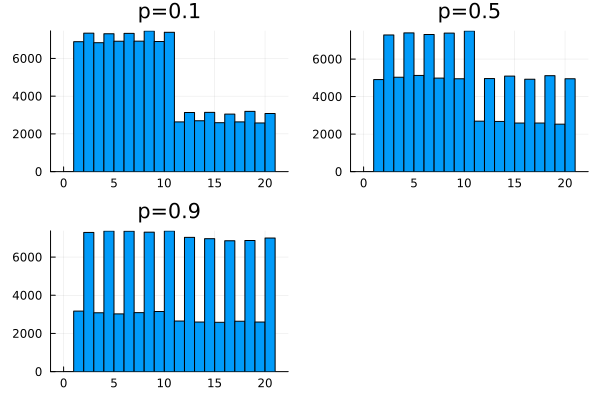

In [2]:
using Plots

bins = collect(range(0, 21))

function plot_histogram(p)
    histogram([f(p) for _=1:100000], bins=bins, title="p=$p", label=nothing)
end

plot(map(plot_histogram, [0.1, 0.5, 0.9])...)

Suppose we wanted to see what the distribution on return values would be if the initial value of `n` was `2`. Because we don't know what random values were sampled during a given execution, we can't use simulations of `f` to answer this question. We would have to modify `f` first, to return the initial value of `n`:

In [3]:
function f_with_initial_n(p)
    initial_n = uniform_discrete(1, 10)
    n = initial_n
    if bernoulli(p)
        n *= 2
    end
    result = categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
    return (result, initial_n)
end;

Then, we could only include executions in which our desired events did happen, when making our histogram:

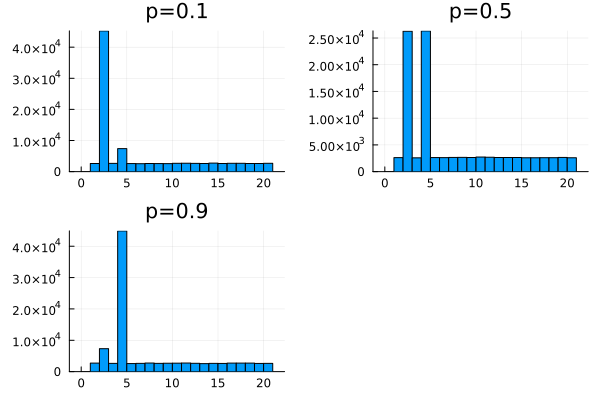

In [4]:
function plot_histogram_filtered(p)
    executions = 0
    results = []
    while executions < 100000
        (result, initial_n) = f_with_initial_n(p)
        if initial_n == 2
            push!(results, result)
            executions += 1
        end
    end
    histogram(results, bins=bins, title="p=$p", label=nothing)
end;
plot(map(plot_histogram_filtered, [0.1, 0.5, 0.9])...)

Suppose we wanted to ask more questions. We might need to modify each time we have a new question, to make sure that the function returns the particular pieces of information about the execution that the question requires.

Note that if the function always returned the value of *every random choice*, then these values are sufficient to answer any question using executions of the function, because all states in the execution of the function are deterministic given the random choices. We will call the record of all the random choies a **trace**. In order to store all the random choices in the trace, we need to come up with a unique name or **address** for each random choice.

Below, we implement the trace as a dictionary that maps addresses of random choices to their values. We use a unique Julia `Symbol` for each address:

In [8]:
function f_with_trace(p)
    trace = Dict()
    
    initial_n = uniform_discrete(1, 10)
    trace[:initial_n] = initial_n
    
    n = initial_n
    
    do_branch = bernoulli(p)
    trace[:do_branch] = do_branch
    
    if do_branch
        n *= 2
    end
    
    result = categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
    trace[:result] = result
    
    return (result, trace)
end;

We run the function, and get the return value and the trace:

In [11]:
f_with_trace(0.3)

(3, Dict{Any, Any}(:result => 3, :do_branch => false, :initial_n => 3))

However, this program looks more complicated than the original program. We could make the syntax for tracing more concise:

In [12]:
function add_to_trace!(trace, value, address)
    trace[address] = value
    return value
end

function f_with_trace_improved(p)
    trace = Dict()
    n = add_to_trace!(trace, uniform_discrete(1, 10), :initial_n)
    if add_to_trace!(trace, bernoulli(p), :do_branch)
        n *= 2
    end
    result = add_to_trace!(trace, categorical([i == n ? 0.5 : 0.5/19 for i=1:20]), :result)
    return (result, trace)
end;

We run the function, and get the return value and the trace:

In [13]:
f_with_trace_improved(0.3)

(17, Dict{Any, Any}(:result => 17, :do_branch => true, :initial_n => 4))

Now that we have instrumented the function, we can answer the following different question without needing to modify the function:

"What is the probability that the branch was taken, given that the result took the value 4?"

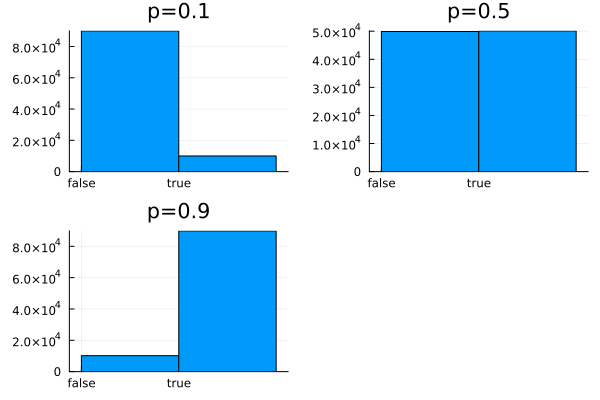

In [14]:
function query(p, observed_result_value::Int)
    executions = 0
    do_branch = []
    while executions < 100000
        (result, trace) = f_with_trace_improved(p)
        if trace[:result] == observed_result_value
            push!(do_branch, trace[:do_branch])
            executions += 1
        end
    end
    histogram(do_branch, bins=[0, 1, 2], align="left", title="p=$p", 
        label=nothing, xticks=(0:1, ["false", "true"]))
#    xticks([0, 1], ["false", "true"])
#    title("p = $p")
end;

plot(map(p -> query(p, 4), [0.1, 0.5, 0.9])...)

What about a result value that is greater than 10?

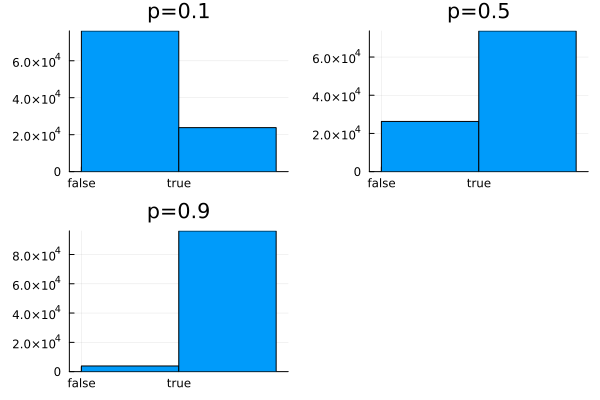

In [15]:
plot(map(p -> query(p, 14), [0.1, 0.5, 0.9])...)

## 2. Tracing the values of random choices in generative functions

The ability to *trace* the values of random choices in a probabilistic program (i.e. record the value of each choice in a trace data structure) is one of the basic features of Gen's built-in modeling language. To write a function in this language we use the `@gen` macro provided by Gen. Note that the built-in modeling language is just one way of defining a [generative function](https://www.gen.dev/docs/stable/ref/distributions/).

Below, we write a `@gen function` version of the function `f` defined above, this time using Gen's tracing instead of our own:

In [16]:
using Gen: @gen

@gen function gen_f(p)
    n = {:initial_n} ~ uniform_discrete(1, 10)
    if ({:do_branch} ~ bernoulli(p))
        n *= 2
    end
    return {:result} ~ categorical([i == n ? 0.5 : 0.5/19 for i=1:20])
end;

The `{address} ~ distribution(args...)` expression records the value of the given random choice at the given address into an *implicit trace data structure*. The trace data structure itself is not a variable in the function, and that code in the body of the function cannot read from the trace. It is an error to use this syntax with the same address twice. Addresses can be arbitrary Julia values. In this notebook, all the addresses will be Julia symbols.

Also note that the trace is not part of the return value:

In [17]:
gen_f(0.3)

7

To run a `@gen` function and get a trace of the execution, we use the [`simulate`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.simulate) method:

In [18]:
using Gen: simulate
trace = simulate(gen_f, (0.3,));

We can access the values of random choices by indexing into the trace:

In [19]:
trace[:initial_n]

1

We can also print the values of all choices made:

In [20]:
using Gen: get_choices

get_choices(trace)

│
├── :result : 1
│
├── :do_branch : false
│
└── :initial_n : 1


Gen also stores the arguments on which the function was called:

In [21]:
using Gen: get_args

get_args(trace)

(0.3,)

and the return value:

In [22]:
using Gen: get_retval

get_retval(trace)

1

Now, we will answer the question "What is the probability that the branch was taken, given that the result took the value 14?" using our `@gen` function (reject sampling):

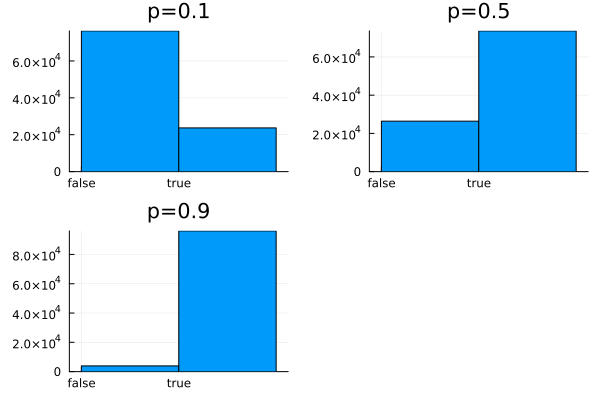

In [23]:
function gen_query(p, observed_result_value::Int)
    executions = 0
    do_branch = []
    while executions < 100000
        trace = simulate(gen_f, (p,))
        if trace[:result] == observed_result_value
            push!(do_branch, trace[:do_branch])
            executions += 1
        end
    end
    histogram(do_branch, bins=[0, 1, 2], align="left", title="p=$p", 
        label=nothing, xticks=(0:1, ["false", "true"]))
end;
plot(map(p -> gen_query(p, 14), [0.1, 0.5, 0.9])...)

## 3. The probability distribution represented by a generative function

A generative function that terminates with probability one has a probability distribution on its executions. We represent an execution of the function as the map from addresses of random choices to their values. We call this map a **choice map** (denoted mathematically by $t$). Then, for given arguments to the function (denoted mathematically by $x$), we can list the possible choice maps, and we can compute the probability of each choice map (denoted $p(t; x)$) by taking the product of the probability of each random choice in the map. We can also compute the return value of the function from the arguments and the choice map (the function that computes the return value is denoted mathematically by $f(x ,t)$). Let's do this for a simple function `foo`:

In [24]:
@gen function foo(prob_a)
    val = true
    if ({:a} ~ bernoulli(prob_a))
        val = ({:b} ~ bernoulli(0.6)) && val
    end
    prob_c = val ? 0.9 : 0.2
    val = ({:c} ~ bernoulli(prob_c)) && val
    return val
end;

$$
\begin{array}{l|l|l}
\mbox{Random choice map } t & \mbox{Probability } p(t; x) & \mbox{Return value } f(x, t) \\
\hline
\{a \mapsto \mbox{true}, b \mapsto \mbox{true}, c \mapsto \mbox{true}\} & \mbox{prob_a} \cdot 0.6\cdot 0.9 & \mbox{true}\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{true}, c \mapsto \mbox{false}\} & \mbox{prob_a} \cdot 0.6 \cdot 0.1 & \mbox{false}\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{false}, c \mapsto \mbox{true}\} & \mbox{prob_a} \cdot 0.4 \cdot 0.2 & \mbox{false}\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{false}, c \mapsto \mbox{false}\} & \mbox{prob_a} \cdot 0.4 \cdot 0.8 & \mbox{false}\\
\{a \mapsto \mbox{false}, c \mapsto \mbox{true}\} & (1-\mbox{prob_a}) \cdot 0.9 & \mbox{true}\\
\{a \mapsto \mbox{false}, c \mapsto \mbox{false}\} & (1-\mbox{prob_a}) \cdot 0.1 & \mbox{false}
\end{array}
$$

Check your understanding by deriving by hand the probability and return value for a few rows of this table.

Based on our table, the probability that `foo` returns `true` is:

In [25]:
prob_true(prob_a) = prob_a * 0.6 * 0.9 + (1-prob_a) * 0.9;

Let's check that using some simulations:

In [26]:
for prob_a in [0.1, 0.5, 0.9]
    actual = sum([foo(prob_a) for _=1:10000]) / 10000
    println("expected: $(prob_true(prob_a)), actual: $actual")
end

expected: 0.8640000000000001, actual: 0.8609
expected: 0.72, actual: 0.7159
expected: 0.5760000000000001, actual: 0.5731


We can also get the log probability that an individual trace would be generated by the function ($\log p(t; x)$), using the [`get_score`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.get_score) method.

Let's generate a trace below, get its log probability with `get_score`

In [27]:
using Gen: get_score
trace = simulate(foo, (0.3,))
display(get_choices(trace))
println("log probability: $(get_score(trace))")

│
├── :a : true
│
├── :b : true
│
└── :c : false


log probability: -4.017383521085973


Check this value against the hand-computed value in our table above.

## 4. Generating a trace that satisfies certain constraints

So far, we have run generative functions in two ways:
    
1. Using usual Julia call syntax:

    ```julia
        gen_f(0.3)
    ```

2. Using the [`simulate`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.simulate) method:

    ```julia
        trace = simulate(gen_f, (0.3,))
    ```

We can also generate a trace that satisfies a set of constraints on the valus of random choices using the [`generate`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.generate) method. Suppose that we want a trace where `:a` is always `true` and `:c` is always `false`. We first construct a choice map containing these constraints:

In [28]:
using Gen: choicemap

constraints = choicemap((:a, true), (:c, false))

│
├── :a : true
│
└── :c : false


The `choicemap` constructor above took two elements of the form `(address, value`). This is equivalent to constructing an empty choice map and then populating it:
```julia
choices = choicemap()
choices[:a] = true
choices[:c] = false
```

Then, we pass the constraints as the third argument to `generate`, after the function itself and the arguments:

In [29]:
using Gen: generate

(trace, weight) = generate(foo, (0.3,), constraints);

Note that we also get a weight in addition to the trace. We will discuss the weight shortly.


Let's check that the trace actually agrees with our constraints:

In [30]:
get_choices(trace)

│
├── :a : true
│
├── :b : true
│
└── :c : false


We can also check the return value:

In [31]:
get_retval(trace)

false

When we invoke `generate`, the choice map is clearly not being sampled from $p(t; x)$, because $p(t; x)$ can generate 6 possible choice maps, whereas our call to `generate` can only generate 2 possible choice maps. Instead, the generative function employs an **internal proposal distribution** on choice maps $t$, denoted mathematically by $q(t; x, u)$, where $u$ is the choice map for the constraints.

The internal proposal distribution cannot generate a choice map that disagrees with the constraints, and it can only generate choice maps that could possibly be sampled from $p(t; x)$. Furthermore, we also require the internal proposal distribution to have *some probability* of sampling *any* choice map $t$ that agrees with the constraints, and that could be possibly be sampled from $p(t; x)$. These requirements can be summarized by the following:

$$q(t; x, u) > 0 \iff p(t; x) > 0 \land u(a) = t(a) \;\; \forall a \in \mbox{dom}(u) \cap \mbox{dom}(t)$$

where $\mbox{dom}$ stands for 'domain', and gives the set of addresses in a choice map.

The specific internal proposal distribution used by `@gen` functions is based on **ancestral sampling**, which operates as follows: We run the function. To evaluate a `~` expression, we look up the address in the constraints choice map. If the address is present in the constraints choice map, we deterministically return the value stored in the constraints for that address. If the address is not present in the constraints, we sample the value from the distribution in the `~` expression. For the function `foo`, with constraints $u = \{a \mapsto \mbox{true}, c \mapsto \mbox{false}\}$, the internal proposal distribution is:

$$
\begin{array}{l|l}
\mbox{Random choice map } t & q(t; x, u)\\
\hline
\{a \mapsto \mbox{true}, b \mapsto \mbox{true}, c \mapsto \mbox{false}\} & 0.6\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{false}, c \mapsto \mbox{false}\} & 0.4
\end{array}
$$

Check your understanding by deriving this distribution by hand.

The weight returned by `generate` is:

$$\log \frac{p(t; x)}{q(t; x, u)}$$

Let's confirm this using our trace and weight sampled above. Note that we ran `generate` with `prob_a = 0.3`:

In [32]:
if trace[:b]
    # choice map is {a -> true, b -> true, c -> false}
    expected_weight = log(0.3 * 0.6 * 0.1 / 0.6)
else
    # choice map is {a -> true, b -> false, c -> false}
    expected_weight = log(0.3 * 0.4 * 0.8 / 0.4)
end
println("expected_weight: $expected_weight, actual_weight: $weight")

expected_weight: -3.506557897319982, actual_weight: -3.506557897319982


The ability to generate a trace that satisfies constraints, along with the weight, is a useful primitive operation for implementing a class of approximate inference algorithms called **importance resampling**. We can implement importance resampling by (i) generating a collection of traces satisfying the constraints, and associated weights, and (ii) returning one of these traces with probability in proportion to its weight: 

In [ ]:
function my_importance_sampler(gen_fn, args, constraints, num_traces)
    traces = []
    weights = []
    for i=1:num_traces
        (trace, weight) = generate(gen_fn, args, constraints)
        push!(traces, trace)
        push!(weights, weight)
    end
    
    # note: the weights are in log-space, so we exponentiate
    normalized_weights = exp.(weights) / sum(exp.(weights))
    idx = categorical(normalized_weights)
    return traces[idx]
end;

A more efficient and numerically robust implementation of importance resampling is provided in Gen's inference library (see [`importance_resampling`](https://www.gen.dev/docs/stable/ref/inference/#Gen.importance_resampling)).

Suppose our goal is to sample `:a` and `:b` from the conditional distribution given that we have observed `:c` is `false`. That is, we want to sample choice map $t$ with probability $0$ if $t(c) = \mbox{false}$ and otherwise probability:

$$\frac{p(t; x)}{\displaystyle \sum_{t' : t'(c) = \mbox{true}} p(t'; x)}$$

In this simple case, we can compute the probability by hand (assuming `prob_a = 0.3`). There are three choice maps with nonzero probability:

In [ ]:
p1 = 0.3 * 0.6 * 0.1
p2 = 0.3 * 0.4 * 0.8
p3 = 0.7 * 0.1
println(p1 / (p1 + p2 + p3))
println(p2 / (p1 + p2 + p3))
println(p3 / (p1 + p2 + p3))

$$
\begin{array}{l|l}
\mbox{Random choice map } t & \mbox{Conditional probability }\\
\hline
\{a \mapsto \mbox{true}, b \mapsto \mbox{true}, c \mapsto \mbox{true}\} & 0\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{true}, c \mapsto \mbox{false}\} & 0.0978\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{false}, c \mapsto \mbox{true}\} & 0\\
\{a \mapsto \mbox{true}, b \mapsto \mbox{false}, c \mapsto \mbox{false}\} & 0.5217\\
\{a \mapsto \mbox{false}, c \mapsto \mbox{true}\} &  0\\
\{a \mapsto \mbox{false}, c \mapsto \mbox{false}\} & 0.3804
\end{array}
$$

In particular, the probability that `a` is `true` given our condition, is:

In [ ]:
prob_a_true = (p1 + p2) / (p1 + p2 + p3)

We can sample approximately from this disribution using our importance sampler. As we increase the number of traces, the actual distribution approaches the desired distribution:

In [ ]:
import Pkg
Pkg.add("StatsBase")
using StatsBase: mean
function importance_query(p, N)
    constraints = choicemap((:c, false))
    as = [my_importance_sampler(foo, (p,), constraints, N)[:a] for _ in 1:10000]
    est_prob_a_true = mean(as)
    histogram(as, bins=[0, 1, 2], align="left", title="using $N particle(s), estimate: $est_prob_a_true",
        label=nothing, xticks=([0, 1], ["a = false", "a = true"]), titlefontsize=10)
end
    
plot(map(N -> importance_query(0.3, N), [1, 10, 100])...)

Indeed, the estimated probability that `a = true` is approaching the true probability that we manually computed.

## 5. Updating a trace

Gen also provides a primitive for updating a trace to conform with new constraints on its choice map. We can use this to implement iterative inference and local optimization algorithms.

Consider the function `foo` from above. Let's obtain an initial trace:

In [ ]:
(trace, weight) = generate(foo, (0.3,), choicemap((:a, true), (:b, true), (:c, true)));
get_choices(trace)

Now, we use the [`update`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.update) method, to change the value of `:c` from `true` to `false`:

In [ ]:
using Gen: update, NoChange

constraints = choicemap((:c, false))
(new_trace, weight, discard, retdiff) = update(trace, (0.3,), (NoChange(),), constraints)
get_choices(new_trace)

The `update` method returns the new trace, as well as a weight, which the log ratio of probabilities of the new choice map ($t'$) and the old choice map ($t$):

$$\log \frac{p(t'; x')}{p(t; x)}$$

The `update` method also allows you to change the arguments to the function (from $x$ to $x'$), but we will not discuss that in this tutorial.

Let's confirm that the weight matches a manual calculation:

In [ ]:
expected_weight = log(0.3 * 0.6 * 0.1) - log(0.3 * 0.6 * 0.9)

In [ ]:
weight

Doing an update can also cause some addresses to leave the choice map altogether. For example, if we set `:a` to `false`, then choice at address `:b` is no longer include in the choice map.

In [ ]:
(trace, weight, retdiff, discard) = update(trace, (0.3,), (NoChange(),), choicemap((:a, false)))
get_choices(trace)

The *discard* choice map that is returned by `update` contains the valus for any addresses that were removed from the choice map, as well as any the previous values for any addresses that were constrained:

In [ ]:
discard

Note that if we now apply the discard as the constraints, we will get back the original choice map:

In [ ]:
(trace, weight, retdiff, discard) = update(trace, (0.3,), (NoChange(),), discard);

In [ ]:
get_choices(trace)

The new discard choice map now contains the old constraints:

In [ ]:
discard

This illustrates a useful notion of **reversibility** of the `update` method, which will be important when using it as a primitive in Metropolis-Hastings algorithms.